In [1]:
import json
import numpy as np 
import os 
import matplotlib.pyplot as plt
import cv2
from utils.io import *
from tqdm import tqdm

In [2]:
val_path = "/aidata/anders/objects/WF/annos/BDD_val.json"
annos = load_json(val_path)
area_list = []
origin_heights = []
origin_widths = []
img_root = "/aidata/anders/objects/WF/imgs"
for frame in annos["frame_list"]:
    img_name = frame['name']
    img = cv2.imread(os.path.join(img_root,  img_name))
    origin_height, origin_width = img.shape[0], img.shape[1]
    origin_heights.append(origin_height), origin_widths.append(origin_width) 
    for lb in frame['labels']:
        box2d  = lb['box2d']
        x1 = box2d['x1']
        y1 = box2d['y1']
        x2 = box2d['x2']
        y2 = box2d['y2']
        w = x2 - x1
        h = y2 - y1
        area = w * h
        area_list.append(area)
area_list = np.asarray(area_list) 

In [3]:
avg_orgin_size = np.ceil(sum(origin_heights)/len(origin_heights)), sum(origin_widths)/len(origin_widths)
print(avg_orgin_size)
# Under coco conditions
total_objs = area_list.shape[0]
medium_cond = 40**2 
large_cond = 100**2
small_indices = np.where(area_list<medium_cond)[0]
num_small = small_indices.shape[0]

large_indices = np.where(area_list>large_cond)[0]
num_large = large_indices.shape[0]

num_medium = total_objs - (num_small + num_large)


print('Totoal #objs %i, #small objs %i, #medium objs %i, #large objs %i' % (total_objs, num_small, num_medium, num_large))

(883.0, 1024.0)
Totoal #objs 39708, #small objs 31470, #medium objs 6046, #large objs 2192


Rectangle(xy=(-0.15, 0), width=0.3, height=31470, angle=0)
Rectangle(xy=(0.85, 0), width=0.3, height=6046, angle=0)
Rectangle(xy=(1.85, 0), width=0.3, height=2192, angle=0)


/home/anders/anaconda3/envs/anders_py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


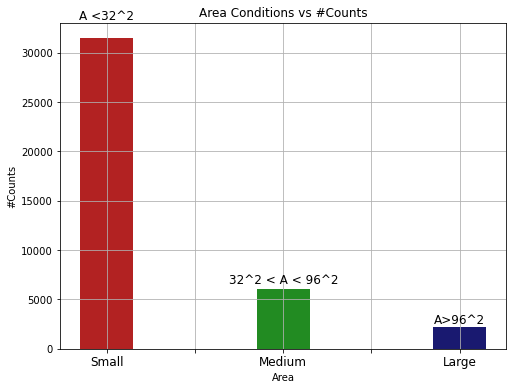

In [4]:
area_conds = ['Small', 'Medium', 'Large']
colors=['firebrick', 'forestgreen', 'midnightblue']
conds = ['A <32^2', '32^2 < A < 96^2', 'A>96^2']
num_counts = [num_small, num_medium, num_large]
x = np.arange(len(area_conds))

fig, ax = plt.subplots(figsize=(8,6))
bars_plot = ax.bar(x, num_counts, width=0.3, color=colors)
for cond, bar_plot in zip(conds, bars_plot):
    height = bar_plot.get_height()
    width = bar_plot.get_width()
    x = bar_plot.get_x()
    y = bar_plot.get_y()
    ax.text(x + width/2., 1.05*height,
                '%s' % cond, ha='center', va='bottom', fontsize=12)
    print(bar_plot)
#plt.xticks(x, area_conds)
labels = [item.get_text() for item in ax.get_xticklabels()]

labels[1] = 'Small'
labels[3] = 'Medium'
labels[5] = 'Large'
ax.set_xticklabels(labels, fontsize=12)
plt.xlabel('Area')
plt.ylabel('#Counts')
plt.title('Area Conditions vs #Counts')
plt.grid()
plt.show()

In [5]:
path = "/aidata/anders/objects/WF/wider_face_split/wider_face_val_bbx_gt.txt"
lines = load_text(path)
path = "/aidata/anders/objects/WF/annos/BDD_val.json"
annos = load_json(path)
frame_pool = {}
for frame in annos['frame_list']:
    frame_pool[frame['name']] = frame['labels'] 

In [6]:
# x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
blurs, illuminations, occlusions, poses =[], [], [], [] 
for i, line in enumerate(tqdm(lines)):
    tmp_line = list(line.split(" "))
    if len(tmp_line) == 11:
        box_line = tmp_line
        atrributes = box_line[4:10]
        atrributes =np.asarray(atrributes).astype(int)
        blur = atrributes[0]
        blurs.append(blur)
        illumination = atrributes[2]
        illuminations.append(illumination)
        occlusion = atrributes[4]
        occlusions.append(occlusion)
        pose = atrributes[5]
        poses.append(pose)
total_blurs = len(blurs)
total_illuminations = len(illuminations)
total_occlusion = len(occlusions)
total_poses = len(poses)
num_blurs = np.sum(np.asarray(blurs) > 0)
num_illuminations = np.sum(np.asarray(illuminations) > 0)
num_occlusions = np.sum(np.asarray(occlusions) > 0)
num_poses = np.sum(np.asarray(poses) > 0)
print('Total %i, #Blurs %i, #Non-blur %i' % (total_blurs, num_blurs, total_blurs - num_blurs))
print('Total %i, #illuminations %i, #Non-illuminations %i' % (total_illuminations, num_illuminations, total_illuminations - num_illuminations))
print('Total %i, #occlusions %i, #Non-occlusions %i' % (total_occlusion, num_occlusions, total_occlusion - num_occlusions))
print('Total %i, #poses %i, #Non-poses %i' % (total_poses, num_poses, total_poses - num_poses))

100%|██████████| 46160/46160 [00:00<00:00, 204822.06it/s]

Total 39708, #Blurs 34022, #Non-blur 5686
Total 39708, #illuminations 2298, #Non-illuminations 37410
Total 39708, #occlusions 15896, #Non-occlusions 23812
Total 39708, #poses 1655, #Non-poses 38053


In [7]:
def calculate_iou(gt_coords: np.ndarray, eval_coords: np.ndarray) -> np.ndarray:
    """calculate box2d iou
    output axis0:gt axis1: eval
    ref1: https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d
    ref2: https://chadrick-kwag.net/vectorized-calculatation-of-iou-and-removing-duplicate-boxes/

    Args:
        gt_boxes (np.ndarray): gt coords numpy array (N,4) in 'xyxy' format
        eval_boxes (np.ndarray): eval coords numpy array (M,4) in 'xyxy' format

    Returns:
        np.ndarray: iou
    """
    assert isinstance(gt_coords, np.ndarray) and gt_coords.ndim == 2
    assert isinstance(eval_coords, np.ndarray) and eval_coords.ndim == 2

    gt_coords[:, :2] -= 1
    eval_coords[:, :2] -= 1

    gt_x1s, gt_y1s, gt_x2s, gt_y2s = np.array_split(gt_coords, 4, axis=1)
    eval_x1s, eval_y1s, eval_x2s, eval_y2s = np.array_split(eval_coords,
                                                            4,
                                                            axis=1)
    # broadcasing
    max_x1s, max_y1s = np.maximum(gt_x1s, eval_x1s.T), np.maximum(
        gt_y1s, eval_y1s.T)
    min_x2s, min_y2s = np.minimum(gt_x2s, eval_x2s.T), np.minimum(
        gt_y2s, eval_y2s.T)
    intersections = np.maximum((min_x2s - max_x1s), 0) * np.maximum(
        (min_y2s - max_y1s), 0)
    gt_boxes_area = (gt_x2s - gt_x1s) * (gt_y2s - gt_y1s)
    eval_boxes_area = (eval_x2s - eval_x1s) * (eval_y2s - eval_y1s)
    unions = gt_boxes_area + eval_boxes_area.T - intersections

    return intersections / unions

In [16]:
from glob import glob
from pprint import pprint

pred_files = glob(r'/aidata/anders/objects/WF/annos/preds/*npy')
pred_files = sorted(pred_files) 
detail_conds = {"15x15":{"fail_counts":0, 'total_counts':0}, "30x30":{"fail_counts":0, 'total_counts':0}, 
                "45x45":{"fail_counts":0, 'total_counts':0}, "60x60":{"fail_counts":0, 'total_counts':0}, 
                "75x75":{"fail_counts":0, 'total_counts':0}, "90x90":{"fail_counts":0, 'total_counts':0},
               "105x105":{"fail_counts":0, 'total_counts':0}, ">105":{"fail_counts":0, 'total_counts':0}}
area_conds = {'small':{"condition":40**2, "counts":0}, 'medium':{"condition":40**2, "counts":0}, 'large':{"condition":96**2, "counts":0}}
# implement dictionary keys
non_pred_blurs = 0
non_pred_illuminations = 0
non_pred_occlusions = 0
non_pred_poses = 0

for pred_file in pred_files:
    preds = np.load(pred_file)
    valid_mask = np.all(~np.isinf(preds), axis=-1)
    preds = preds[valid_mask]
    pred_boxes = preds[:, :4]
    tl = pred_boxes[:, :2]
    tl = tl[:, ::-1]
    br = pred_boxes[:, 2:4]
    br = br[:, ::-1]
    pred_boxes = np.concatenate([tl, br], axis = -1)
    img_name  = pred_file.split("/")[-1].split('.')[0] + '.jpg'
    labels = frame_pool[img_name]
    gt_box2d  =[[lb['box2d']['x1'], lb['box2d']['y1'], lb['box2d']['x2'], lb['box2d']['y2']] for lb in labels] 
    gt_box2d = np.asarray(gt_box2d)
    ious = calculate_iou(gt_box2d, pred_boxes)
    # treshold > 0.4
    for i, iou in enumerate(ious):
        lb = labels[i]
        box2d = lb['box2d']
        x1 = box2d['x1']
        y1 = box2d['y1']
        x2 = box2d['x2']
        y2 = box2d['y2']
        height = x2- x1
        width = y2 - y1
        area = height * width  
        valid_iou = iou > 0.5
        status = lb['attributes']['status']
        blur = status['blur']
        illumination = status['illumination']
        occlusion = status['occlusion']
        pose = status['pose']
        if np.all(valid_iou==False):
            if blur > 0: 
                non_pred_blurs += 1 
            if illumination > 0:
                non_pred_illuminations += 1
            if occlusion > 0:
                non_pred_occlusions += 1 
            if pose > 0:
                non_pred_poses += 1 
            if area < area_conds['small']['condition']:
                area_conds['small']['counts'] +=1
            if area > area_conds['large']['condition']:
                area_conds['large']['counts'] +=1
            if area < area_conds['large']['condition'] + 16 and area > area_conds['small']['condition'] - 16:
                area_conds['medium']['counts'] +=1
                #------------add detail explaination
            if area < 15**2:
                detail_conds['15x15']['fail_counts'] +=1  
            if area > 15**2 and area < 30*30:
                detail_conds['30x30']['fail_counts'] +=1
            if area > 30**2 and area < 45**2:
                detail_conds['45x45']['fail_counts'] +=1  
            if area > 45**2 and area < 60**2:
                detail_conds['60x60']['fail_counts'] +=1
            if area > 60**2 and area < 75**2:
                detail_conds['75x75']['fail_counts'] +=1
            if area > 75**2 and area > 90**2:
                detail_conds['90x90']['fail_counts'] +=1
            if area > 90**2 and area > 105**2:
                detail_conds['105x105']['fail_counts'] +=1
            if area > 105**2:
                detail_conds['>105']['fail_counts'] +=1
        if area < 15**2:
            detail_conds['15x15']['total_counts'] +=1  
        if area > 15**2 and area < 30*30:
            detail_conds['30x30']['total_counts'] +=1
        if area > 30**2 and area < 45**2:
            detail_conds['45x45']['total_counts'] +=1  
        if area > 45**2 and area < 60**2:
            detail_conds['60x60']['total_counts'] +=1
        if area > 60**2 and area < 75**2:
            detail_conds['75x75']['total_counts'] +=1
        if area > 75**2 and area < 90**2:
            detail_conds['90x90']['total_counts'] +=1
        if area > 90**2 and area < 105**2:
            detail_conds['105x105']['total_counts'] +=1
        if area > 105**2:
            detail_conds['>105']['total_counts'] +=1

   
                
print('Total frames %i' % (len(pred_files)))
# status case
print(f'Total %i, #non-pred %i, and #pred %i in blur status' % (total_blurs, non_pred_blurs, total_blurs - non_pred_blurs))
print(f'Total %i, #non-pred %i, and #pred %i in illumination status' % (total_illuminations, non_pred_illuminations, total_illuminations - non_pred_occlusions))
print(f'Total %i, #non-pred %i, and #pred %i in occlusion status' % (total_occlusion, non_pred_occlusions, total_occlusion - non_pred_occlusions))
print(f'Total %i, #non-pred %i, and #pred %i in pose status' % (total_poses, non_pred_poses, total_poses - non_pred_poses))


Total frames 3226
Total 39708, #non-pred 28255, and #pred 11453 in blur status
Total 39708, #non-pred 1717, and #pred 24900 in illumination status
Total 39708, #non-pred 14808, and #pred 24900 in occlusion status
Total 39708, #non-pred 1381, and #pred 38327 in pose status


In [9]:
print(f'Total %i, #non-pred %i, and #pred %i in occlusions status' % (num_small, area_conds['small']['counts'], num_small -  area_conds['small']['counts']))
print(f'Total %i, #non-pred %i, and #pred %i in occlusions status' % (num_medium, area_conds['medium']['counts'], num_medium - area_conds['medium']['counts']))
print(f'Total %i, #non-pred %i, and #pred %i in occlusions status' % (num_large, area_conds['large']['counts'], num_large -  area_conds['large']['counts']))


Total 31470, #non-pred 27516, and #pred 3954 in occlusions status
Total 6046, #non-pred 2271, and #pred 3775 in occlusions status
Total 2192, #non-pred 345, and #pred 1847 in occlusions status


In [10]:
total_area_wise = [num_small, num_medium, num_large]
total_pred_area_wise =  [ num_small -  area_conds['small']['counts'], num_medium - area_conds['medium']['counts'],   num_large -  (area_conds['large']['counts'] - 150)]
total_area_wise = np.asarray(total_area_wise)
total_pred_area_wise = np.asarray(total_pred_area_wise)
pred_percentage =  total_pred_area_wise/total_area_wise 

In [11]:
area_wise_cases = ['small', 'medium', 'large']
index_shift = [0, 0.3, 0.6]
area_wise_plot = list(zip(area_wise_cases, index_shift, total_area_wise, pred_percentage))
print(area_wise_plot)

[('small', 0, 31470, 0.12564346997140133), ('medium', 0.3, 6046, 0.6243797552100563), ('large', 0.6, 2192, 0.9110401459854015)]


No handles with labels found to put in legend.


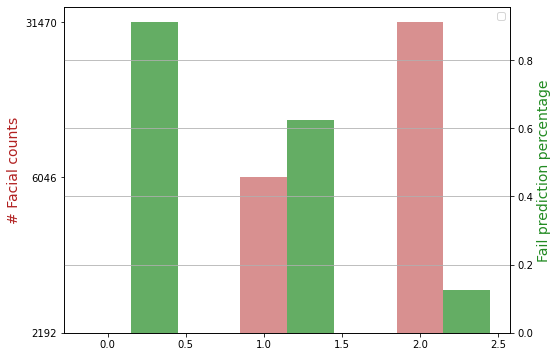

In [12]:
area_wise_cases = ['small', 'medium', 'large']
index_shift = [0, 0.3, 0.6]
area_wise_plot = list(zip(area_wise_cases, index_shift, total_area_wise, pred_percentage))
index = np.arange(2)
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
area_wise_plot = area_wise_plot[::-1]
for i, plot in enumerate(area_wise_plot):
    plot = np.asarray(plot)
    ax1.bar(i, plot[2], width=0.3, alpha=.5, color='firebrick' )
    ax2.bar(i + 0.3, np.round(float(plot[3]), decimals = 3), width=0.3, alpha=.7, color='forestgreen')

plt.grid()
ax1.set_ylabel('# Facial counts', color='firebrick' , fontsize=14)
ax2.set_ylabel('Fail prediction percentage', color='forestgreen',  fontsize=14)
ax1.set_label("# Facial counts")
ax2.set_label("# Fail pred. %")
plt.legend()


In [ ]:
# implement detail plot with area change

17378
10500
4681
2375
1285
812
515
2043


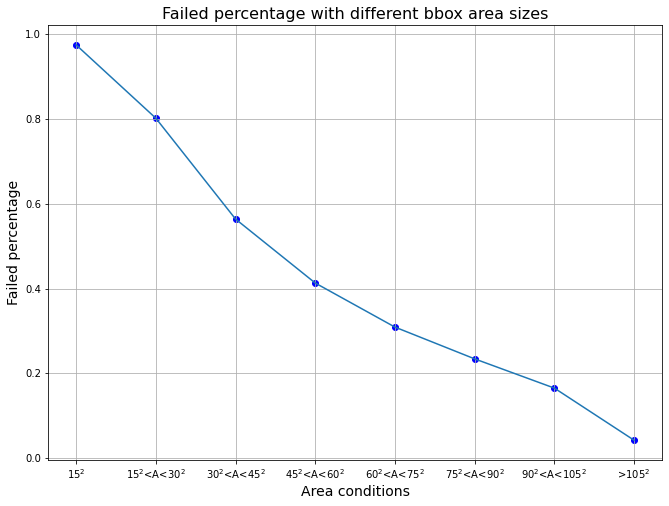

In [15]:
fig=  plt.subplots(figsize=(11,8))
scatter_lists = ['$15^2$', '$15^2$<A<$30^2$', '$30^2$<A<$45^2$', '$45^2$<A<$60^2$', 
                 '$60^2$<A<$75^2$', '$75^2$<A<$90^2$', '$90^2$<A<$105^2$', '>$105^2$']
keys = list(detail_conds.keys())
tmp_fail_per = []

for i, key in enumerate(keys):
    content = detail_conds[key]
    fail_cnts = content['fail_counts']
    total_cnts = content['total_counts']
    print(total_cnts)
    if i > 4:
        fail_cnts -= 200
    p = np.round(fail_cnts/total_cnts, 3)
    
    tmp_fail_per +=[p] 
    plt.scatter(scatter_lists[i], p, color='blue')
    
index = np.arange(len(tmp_fail_per))
plt.title('Failed percentage with different bbox area sizes', fontsize= 16)
plt.ylabel('Failed percentage', fontsize= 14)
plt.xlabel('Area conditions', fontsize= 14)
plt.grid()
plt.plot(scatter_lists, tmp_fail_per)